# LALSimulation
This uses LALSimulation. The reason this has been put on pause as ```XLAL Error - XLALSimIMRSpinAlignedEOBModes: Ringdown frequency > Nyquist frequency!``` is an error that keeps popping up because I'm struggling to actually change the parameter_check() values.

We're using OOP to create a LALCompactBinaryCoalescenseGenerator object: https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/classlalsimulation_1_1gwsignal_1_1core_1_1waveform_1_1_l_a_l_compact_binary_coalescence_generator.html

In [2]:
%matplotlib inline

import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wv
from astropy import units as u
import matplotlib.pyplot as plt

/home/brett/anaconda3/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


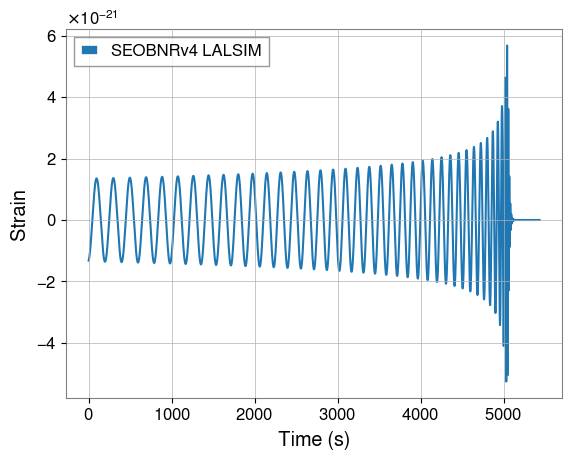

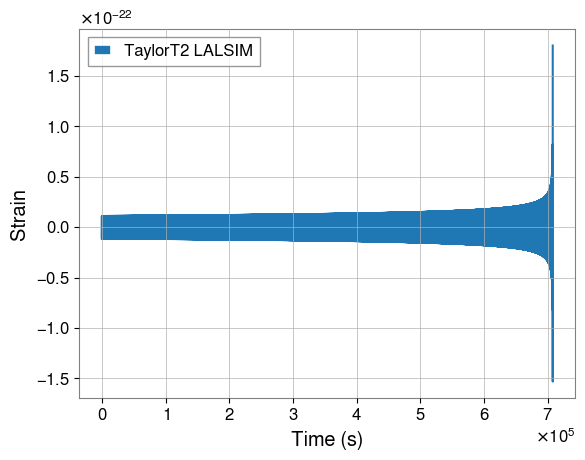

In [3]:
labels = ['SEOBNRv4', 'TaylorT2', 'SEOBNRv4_ROM_NRTidalv2_NSBH']
m1 = [30, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
m2 = [20, 1.5, 1.5]

# we need to figure out all these values
dt = 1./4096
df = 1./4
dist = 100
fmin = 10
fref = 20
fmax = 2000

lalsim_data = []
if __name__=='__main__':
    approxs = [lalsimulation.SEOBNRv4, lalsimulation.TaylorT2, lalsimulation.SEOBNRv4_ROM_NRTidalv2_NSBH]
    parentWV = wv.CompactBinaryCoalescenceGenerator()
    
    for i in range(2):
        waveform = wv.LALCompactBinaryCoalescenceGenerator(approxs[i])
        lalsim_data.append(waveform.generate_td_waveform(mass1 = m1[i]*u.solMass,
                                                         mass2 = m2[i]*u.solMass,
                                                         deltaT = dt*u.s, 
                                                         deltaF = df*u.Hz,
                                                         distance = dist*u.Mpc,
                                                         f_max = fmax*u.Hz))

        plt.plot(range(len(lalsim_data[i][i])), lalsim_data[i][0], label=labels[i]+" LALSIM") #solve the time issue

        plt.ylabel('Strain')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

# PyCBC
For this I tried using PyCBC, with https://pycbc.org/pycbc/latest/html/waveform.html as a reference point.

The most common error I'm receiving is ```XLAL Error - SEOBNRv4ROMCore (LALSimIMRSEOBNRv4ROM.c:772): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH```. Which I'm receiving as an error for LALSimulation as well when I attempt to use SEOBNRv4_ROM_NRTidalv2_NSBH. Besides this, PyCBC seems to be working far better than LALSimulation, and it's also built on using LALSimulation.

This is also very loud at 0? Which I don't like the look of.

In [5]:
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform

[-8.45980853 -8.45956439 -8.45932025 ...  0.09390241  0.09414655
  0.09439069]


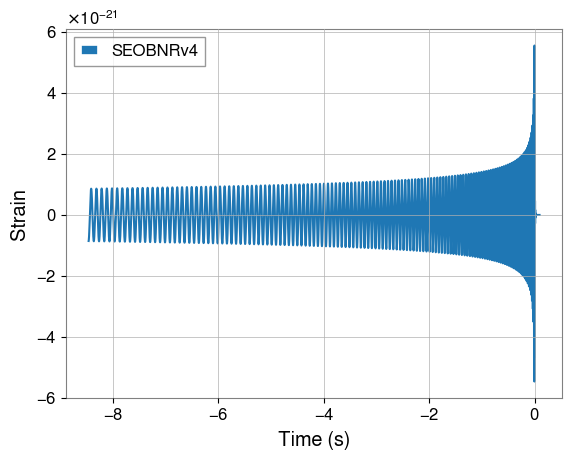

[-1.09261646e+03 -1.09261621e+03 -1.09261597e+03 ...
 -7.32421750e-04 -4.88281125e-04 -2.44140500e-04]


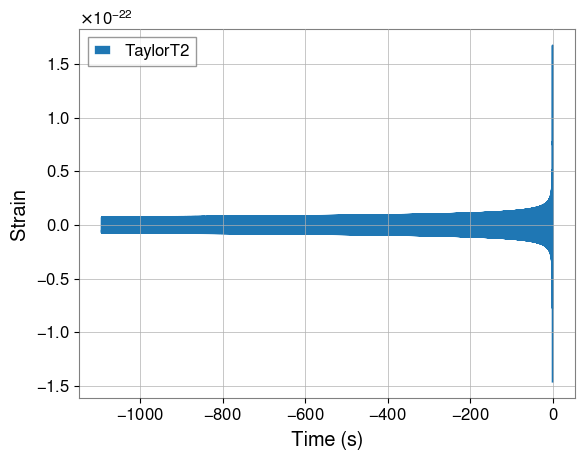

In [6]:
m1 = [30, 1.2, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
m2 = [20, 1.5, 1.5]
for i in range(2):
    hp, hc = get_td_waveform(approximant=labels[i], mass1=m1[i], mass2=m2[i], delta_t=dt,
                             delta_f=df, distance=dist, f_final = fmax, f_lower = fmin)
    plt.plot(hp.sample_times, hp, label=labels[i])
    print(hp.sample_times)
    plt.ylabel('Strain')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()

# Data Whitening

In [8]:
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import numpy as np

In [9]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

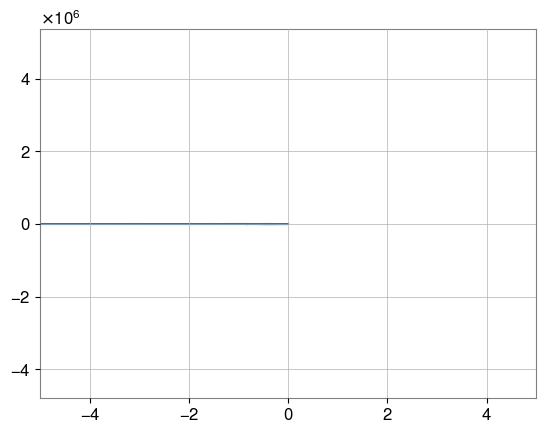

In [10]:
j = 1
hp, hc = get_td_waveform(approximant=labels[j], mass1=m1[j], mass2=m2[j], delta_t=1.0/4096,
                         f_lower=20, distance=100, f_ref=20, delta_f=1./4, f_final = 2048)
def preprocessing(data, time):
    fs = 4096
    NFFT = 1*fs
    pxx, freq = mlab.psd(data, Fs = fs, NFFT = NFFT) #obtains transformed signal via welch's psd
    psd = interp1d(freq, pxx) # constructs the interpolated function
    dt = time[1]-time[0] # time binning
    whitened_SEOBNRv4 = whiten(data, psd, dt)

    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_SEOBNRv4 = filtfilt(bb, ab, whitened_SEOBNRv4)
    strain_L1_shift = np.roll(whitened_SEOBNRv4,int(fs))
    plt.plot(time, strain_L1_shift, label=labels[i])
    plt.xlim([-5, 5])
    plt.show()

processed = preprocessing(hp, hp.sample_times)

In [11]:
import h5py

# LIGO-specific readligo.py 
import readligo as rl

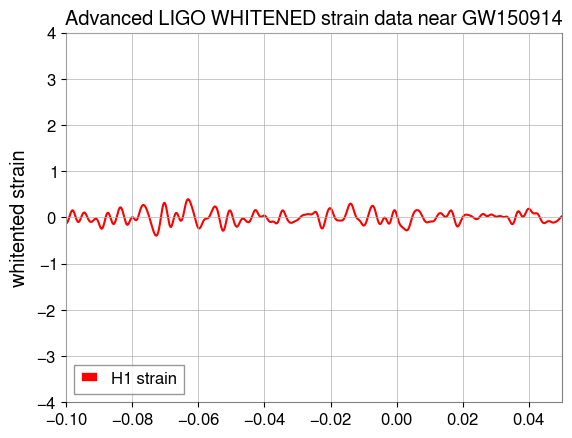

In [12]:
fn_H1 = '/home/brett/Downloads/H-H1_GWOSC_O3b_4KHZ_R1-1256697856-4096.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')

fs = 4096
time = time_H1
dt = time[1] - time[0]

def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

NFFT = 1*fs
fmin = 10
fmax = 2000
tevent = (time[-1]-time[0])/2+time[0]

Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)

strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)

tevent = (time[-1]-time[0])/2+time[0]
plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
#plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

# Other Resources
- https://github.com/Chaitany1729/nn_for_gw
- https://github.com/eric-moreno/Anomaly-Detection-Autoencoder
- https://github.com/timothygebhard/ggwd/

In [14]:
%matplotlib inline

import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wv
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import h5py
import random
import scipy.signal as sg

from astropy import units as u
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, medfilt
import readligo as rl
from gwpy.timeseries import TimeSeries
from scipy import integrate

In [15]:
labels = ['SEOBNRv4', 'TaylorT2', 'SEOBNRv4_ROM_NRTidalv2_NSBH']
mass1 = [2, 1, 19.5] #varying masses based on aprox we're using. for i = 3, m1 >= m2
mass2 = [95, 2, 1.5]

fmin = 20
fref = 20
fmax = 2000
fn_H1 = '/home/brett/Downloads/H-H1_GWOSC_O3b_4KHZ_R1-1256697856-4096.hdf5'
num_of_waveform = 100

# we need to figure out all these values
dt = 1./4096
df = 1./4
dist = 100
fs = 4096 #I think this should be 4096, but if i put it that i get ringdown freq > nyquist freq
NFFT = 1*fs

In [24]:
lalsim_data = [[], []]

if __name__=='__main__':
    approxs = [lalsimulation.SEOBNRv4, lalsimulation.TaylorT2]#, lalsimulation.SEOBNRv4_ROM_NRTidalv2_NSBH]
    parentWV = wv.CompactBinaryCoalescenceGenerator()
    
    for i in [0, 1]:
        while len(lalsim_data[i]) < num_of_waveform:
            m1 = random.randint(mass1[i], mass2[i])
            m2 = random.randint(mass1[i], mass2[i])
            while m1/m2 > 10:
                m2 = random.randint(2,95)
            waveform = wv.LALCompactBinaryCoalescenceGenerator(approxs[i])
            lalsim_data[i].append(waveform.generate_td_waveform(mass1 = m1*u.solMass,
                                                             mass2 = m2*u.solMass,
                                                             deltaT = dt*u.s, 
                                                             deltaF = df*u.Hz,
                                                             distance = dist*u.Mpc,
                                                             f_max = fmax*u.Hz))

In [25]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def preprocessing(data, dt, t0):
    pxx, freq = mlab.psd(data, Fs = fs, NFFT = len(data)) #obtains transformed signal via welch's psd
    psd = interp1d(freq, pxx) # constructs the interpolated function
    whitened_SEOBNRv4 = whiten(data, psd, dt)
    
    #bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    #strain_SEOBNRv4 = filtfilt(bb, ab, whitened_SEOBNRv4)
    
    shift = -(t0/dt)
    strain_L1_shift = np.roll(whitened_SEOBNRv4,int(shift))
    return strain_L1_shift

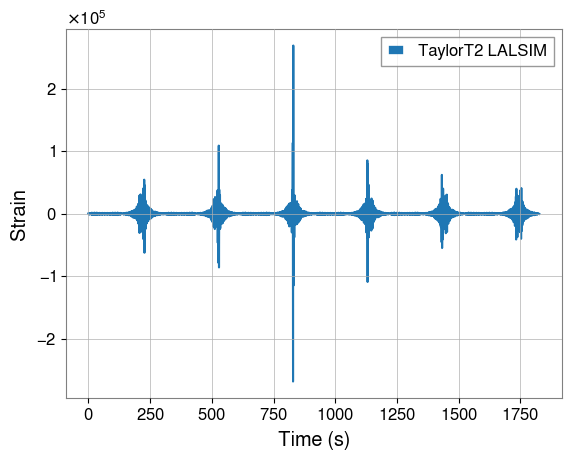

In [26]:
x = lalsim_data[0][10][0]
x = preprocessing(x, x.dt.value, x.t0.value)
plt.plot(range(len(x)), x, label=labels[1]+" LALSIM") #solve the time issue
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [27]:
def h_tilde(f, i):
    idx = i  # Waveform index
    waveform_data = processed_SEOBNRv4[idx] # Waveform data from SEOBNRv4 index
    
    # FT data
    h_tilde_data = np.fft.rfft(waveform_data)
    
    # Interpolate to evaluate at frequency
    h_tilde_interp = interp1d(np.fft.rfftfreq(len(waveform_data), dt), h_tilde_data)
    
    return h_tilde_interp

def optimal_snr_squared(h_tilde, psd):
    def integrand(f):
        return np.abs(h_tilde(f))**2 / psd(f)

    result, _ = integrate.quad(integrand, fmin, fmax)
    rho_opt_squared = 4 * result

    return rho_opt_squared

from pycbc.filter import matched_filter

def snr(data, conditioned, psd):
    snr = matched_filter(data, conditioned, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4 + 4, 4)
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr.sample_times, abs(snr))
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]

    print("We found a signal at {}s with SNR {}".format(time, 
                                                        abs(snrp)))

In [28]:
processed_seo = []
processed_taylor = []

for i in range(num_of_waveform):
    proc = preprocessing(lalsim_data[0][i][0], lalsim_data[0][i][0].dt.value, lalsim_data[0][i][0].t0.value)
    processed_seo.append(proc)
    
for i in range(num_of_waveform):
    proc = preprocessing(lalsim_data[1][i][0], lalsim_data[1][i][0].dt.value, lalsim_data[1][i][0].t0.value)
    processed_taylor.append(proc)

In [29]:
H1s = ['/home/brett/Downloads/H-H1_GWOSC_O3b_4KHZ_R1-1256697856-4096.hdf5']
H1_noise = []
for fn_H1 in H1s:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')

    time = time_H1
    dt = time[1] - time[0]
    tevent = (time[-1]-time[0])/2+time[0]
    
    strain_H1_preprocess = preprocessing(strain_H1, dt, -dt)
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
    H1_noise.append(strain_H1_whitenbp)

In [30]:
j = 10
final_seo = []
final_taylor = []

scale_seo = []
scale_taylor = []

for j in range(num_of_waveform):
    #snr = optimal_snr_squared(h_tilde(j), psd_H1)
    scale_seo.append(1.5*processed_seo[j]/np.max(processed_seo[j]))
    scale_taylor.append(1.5*processed_taylor[j]/np.max(processed_taylor[j]))

    center = int(len(strain_H1_whitenbp)/2)
    final_seo.append(np.add(strain_H1_whitenbp[center:center+len(scale_seo[j])], scale_seo[j]))
    final_taylor.append(np.add(strain_H1_whitenbp[center:center+len(scale_taylor[j])], scale_taylor[j]))

tevent = (time[-1]-time[0])/2+time[0]

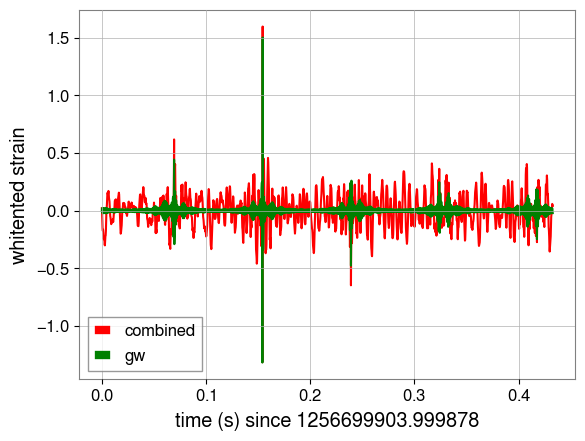

In [31]:
plt.figure()
plt.plot(time[center:center+len(final_seo[0])]-tevent, final_seo[0],'r',label='combined')
plt.plot(time[center:center+len(scale_seo[0])]-tevent, scale_seo[0],'g',label='gw')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.show()

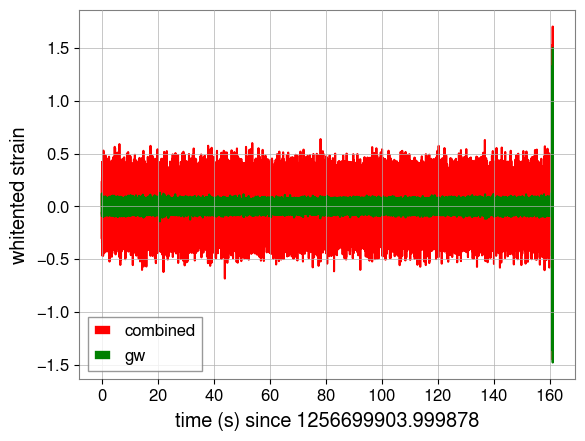

In [32]:
plt.figure()
plt.plot(time[center:center+len(final_taylor[0])]-tevent, final_taylor[0],'r',label='combined')
plt.plot(time[center:center+len(scale_taylor[0])]-tevent, scale_taylor[0],'g',label='gw')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.show()

In [33]:
final_taylor
final_seo

[<TimeSeries([ 0.02034133, -0.01832187, -0.0902985 , ...,
               0.05809661,  0.04962353,  0.04152397]
             unit=Unit(dimensionless),
             t0=<Quantity -0.15430591 s>,
             dt=<Quantity 0.00024414 s>,
             name='hplus',
             channel=None)>,
 <TimeSeries([ 0.02281094, -0.03787029, -0.09593464, ...,
               0.14286052,  0.08473878,  0.03625858]
             unit=Unit(dimensionless),
             t0=<Quantity -0.42167663 s>,
             dt=<Quantity 0.00024414 s>,
             name='hplus',
             channel=None)>,
 <TimeSeries([ 0.02627082, -0.04284689, -0.09332456, ...,
              -0.25994616, -0.25543607, -0.21620546]
             unit=Unit(dimensionless),
             t0=<Quantity -0.22632044 s>,
             dt=<Quantity 0.00024414 s>,
             name='hplus',
             channel=None)>,
 <TimeSeries([ 0.02122558, -0.03708138, -0.09828389, ...,
              -0.30680103, -0.39907165, -0.4534389 ]
             unit=Unit

In [35]:
print(len(final_taylor))

100


In [36]:
print(len(final_seo))

100


-0.07326961437560844


In [65]:
np.savetxt('/home/brett/Desktop/test_data.txt', final_taylor[0].value, delimiter=',')

In [57]:
type(final_taylor[0])

gwpy.timeseries.timeseries.TimeSeries

In [61]:
numpy.(final_taylor[0])

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ numpy.(final_taylor[0])                                                                          │
│       ▲                                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [63]:
final_taylor[0].value

array([-0.06306662, -0.08219197, -0.11299057, ..., -0.59705597,
       -1.19922973,  1.52770522])